In [44]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import json
# import plotly.graph_objects as go
import plotly.express as px

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# import spacy

import time
import string


# from sklearn.

from sklearn.neural_network import MLPClassifier

# MODELS
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# EVALUATION METRICS and TOOLS
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report


# OTHER TOOLS
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import  HalvingGridSearchCV, RepeatedStratifiedKFold, cross_val_score, train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from utils import main as utils, plots, preprocessing


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alhas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alhas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('data/en_data.csv', encoding='utf-8')

In [9]:
df.iloc[796].textrecord

'{{224}}  {{491}}  {{013}} The ascent was very rapid, and after rising about 2000 feet, we found ourselves clear of all other trees but pines. The immense load of snow which they bore had forced their branches almost to their sides, and in this position each tree stood clear of its fellow. Their slight stems at first entirely misled'

In [45]:
preprocessing.tokenize_data('''Before the trap is reset it is washed to get rid of any slime or seaweed that may adhere to it. The hand is then aved ackwards and forwards over the sand at the bottom to stir it up. This also brings out the ~~puapua'i~~ smell. The trap is then put back and theones and coral house replaced.''', exclude=['fishing'])

['Before',
 'the',
 'trap',
 'is',
 'reset',
 'it',
 'is',
 'washed',
 'to',
 'get',
 'rid',
 'of',
 'any',
 'slime',
 'or',
 'seaweed',
 'that',
 'may',
 'adhere',
 'to',
 'it',
 'The',
 'hand',
 'is',
 'then',
 'aved',
 'ackwards',
 'and',
 'forward',
 'over',
 'the',
 'sand',
 'at',
 'the',
 'bottom',
 'to',
 'stir',
 'it',
 'up',
 'This',
 'also',
 'brings',
 'out',
 'the',
 'puapuai',
 'smell',
 'The',
 'trap',
 'is',
 'then',
 'put',
 'back',
 'and',
 'theones',
 'and',
 'coral',
 'house',
 'replaced']

In [103]:
def tokenize_data(doc, **kwargs):
    if preprocessing.insufficient_info(doc):
        return []

    tokens = nlp(doc)
    
    tokens = [token.lemma_ for token in tokens if 
              (token.is_alpha or token.is_digit) and
              not token.is_punct and 
              not token.is_stop
             ]
    
    if kwargs.get('exclude'):
        print(tokens)
        tokens = [word for word in tokens if not np.any([re.match(word, t) for t in kwargs.get('exclude')])]
    return tokens

In [ ]:
nlp('tests here', disable=[])

In [104]:
tokenize_data('''[%Before the trap is reset it is washed to get rid of any slime or seaweed that may adhere to it. The hand is then aved ackwards and forwards over the sand at the bottom to stir it up. This also brings out the ~~puapua'i~~ smell. The trap is then put back and theones and coral house replaced.''', exclude=['fishing'])

['trap', 'reset', 'wash', 'rid', 'slime', 'seaweed', 'adhere', 'hand', 'ave', 'ackward', 'forwards', 'sand', 'stir', 'bring', 'smell', 'trap', 'theone', 'coral', 'house', 'replace']


['trap',
 'reset',
 'wash',
 'rid',
 'slime',
 'seaweed',
 'adhere',
 'hand',
 'ave',
 'ackward',
 'forwards',
 'sand',
 'stir',
 'bring',
 'smell',
 'trap',
 'theone',
 'coral',
 'house',
 'replace']

In [83]:
nlp("""Before the trap is reset it is washed to get rid of any slime or seaweed that may adhere to it. The hand is then aved ackwards and forwards over the sand at the bottom to stir it up 2!""").set_ents)

TypeError: 'builtin_function_or_method' object is not iterable

In [73]:
for t in nlp("""Before the trap is reset it is washed to get rid of any slime or seaweed that may adhere to it. The hand is then aved ackwards and forwards over the sand at the bottom to stir it up 2!"""):
    print(t, t.is_punct, t.is_alpha, t.is_digit, t.is_stop,)

Before False True False True
the False True False True
trap False True False False
is False True False True
reset False True False False
it False True False True
is False True False True
washed False True False False
to False True False True
get False True False True
rid False True False False
of False True False True
any False True False True
slime False True False False
or False True False True
seaweed False True False False
that False True False True
may False True False True
adhere False True False False
to False True False True
it False True False True
. True False False False
The False True False True
hand False True False False
is False True False True
then False True False True
aved False True False False
ackwards False True False False
and False True False True
forwards False True False False
over False True False True
the False True False True
sand False True False False
at False True False True
the False True False True
bottom False True False True
to False True False True
s

In [ ]:
spacy.se

# Needed functions

In [2]:

with open("data/id_to_label.json", "r") as f:
    # Write the dictionary to the file in JSON format
    id_to_label = json.load(f)

In [3]:
def plot_feature_effects(clf, 
                         X_train,
                         feature_names,
                         target_names,
                         to_labels=False,
                         top_k=5,
                         verbose=False):
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    target_names = np.sort(target_names)
    if to_labels:
        target_names = [id_to_label[i] for i in target_names]
        
    fig, ax = plt.subplots(figsize=(10, 8))

    # Get top k features for each target class
    for i, label in enumerate(target_names):
        # if len(average_feature_effects) > 1:
        #     print(i, 'label', label, average_feature_effects)
        top_indices = np.argsort(average_feature_effects[i if len(average_feature_effects) > 1 else 0])[::-1][:top_k]
        top_k_words = feature_names[top_indices]
        top_k_effects = average_feature_effects[i if len(average_feature_effects) > 1 else 0, top_indices]
        ax.barh(top_k_words, top_k_effects, label=label, alpha=0.5)

    ax.set_xlabel('Average Feature Effects')
    ax.legend()
    ax.set_title(f'Top {top_k} Feature Effects per Target Class')

    if verbose:
        # Display top k keywords for each class in a table
        top_k_keywords = pd.DataFrame()
        for i, label in enumerate(target_names):
            top_indices = np.argsort(average_feature_effects[i if len(average_feature_effects) > 1 else 0])[::-1][:top_k]
            top_k_words = feature_names[top_indices]
            top_k_keywords[label] = top_k_words
        print(f"Top {top_k} Keywords per Class:\n{top_k_keywords}")
    plt.show()
    return ax

In [4]:
def plot_feature_effects(clf, 
                         X_train,
                         feature_names,
                         target_names,
                         df=None, # new argument for dataframe
                         to_labels=False,
                         top_k=5,
                         verbose=False):
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    target_names = np.sort(target_names)
    if to_labels:
        target_names = [id_to_label[i] for i in target_names]
        
    fig, ax = plt.subplots(figsize=(10, 8))

    # Get top k features for each target class
    for i, label in enumerate(target_names):
        # if len(average_feature_effects) > 1:
        #     print(i, 'label', label, average_feature_effects)
        top_indices = np.argsort(average_feature_effects[i if len(average_feature_effects) > 1 else 0])[::-1][:top_k]
        top_k_words = feature_names[top_indices]
        top_k_effects = average_feature_effects[i if len(average_feature_effects) > 1 else 0, top_indices]
        ax.barh(top_k_words, top_k_effects, label=label, alpha=0.5)

    ax.set_xlabel('Average Feature Effects')
    ax.legend()
    ax.set_title(f'Top {top_k} Feature Effects per Target Class')

    if df is not None:
        # Extract culture column from dataframe
        culture_col = df['culture']
        # Concatenate culture column with predicted labels
        predicted_labels = df[f'predicted_{clf.__class__.__name__}']
        df_concat = pd.concat([culture_col, predicted_labels], axis=1)
        # Get top k culture values for each target class
        top_k_culture = pd.DataFrame()
        print(target_names, df_concat)
        for i, label in enumerate(target_names):
            # Filter dataframe to predicted class
            df_class = df_concat[df_concat[f'predicted_{clf.__class__.__name__}'] == i]
            # Get top k culture values
            top_k_culture[label] = df_class['culture'].value_counts().index[:top_k]
        print(f"Top {top_k} Culture Values per Predicted Class:\n{top_k_culture}")

    if verbose:
        # Display top k keywords for each class in a table
        top_k_keywords = pd.DataFrame()
        for i, label in enumerate(target_names):
            top_indices = np.argsort(average_feature_effects[i if len(average_feature_effects) > 1 else 0])[::-1][:top_k]
            top_k_words = feature_names[top_indices]
            top_k_keywords[label] = top_k_words
        print(f"Top {top_k} Keywords per Class:\n{top_k_keywords}")
    plt.show()
    return ax


In [5]:
# def plot_feature_effects(clf, X_train, feature_names, target_names, top_n=5):
#     # learned coefficients weighted by frequency of appearance
#     average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

#     # find top n keywords for each label
#     top_keywords = {}
#     for i, label in enumerate(target_names):
#         top_n_indices = np.argsort(average_feature_effects[i])[::-1][:top_n]
#         top_keywords[label] = [(feature_names[idx], round(average_feature_effects[i, idx], 3)) for idx in top_n_indices]

#     # create a horizontal bar chart for each label
#     fig, axs = plt.subplots(nrows=len(target_names), figsize=(12, 8))
#     for i, label in enumerate(target_names):
#         keywords, importance = zip(*top_keywords[label])
#         axs[i].barh(keywords, importance, color='tab:blue')
#         axs[i].set_xlim(left=-1, right=1)
#         axs[i].set_xlabel('Feature Importance')
#         axs[i].set_title(f'Top {top_n} keywords for {label}')

#     plt.tight_layout()
#     plt.show()


In [6]:
def train_model(model,
                X_train, y_train,
                X_test, y_test,                
                verbose=False):  
        
    if model == 'RF':
        clf = RandomForestClassifier(n_estimators=100)
    # pipe = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=10000))  
    elif model == 'LR':
        clf = LogisticRegression(max_iter=10000)
    elif model == 'NN':
        clf = MLPClassifier(hidden_layer_sizes=(16, ), solver='lbfgs', max_iter=500)
    elif model == 'KN':
        clf = make_pipeline(StandardScaler(with_mean=False),
             KNeighborsClassifier(n_neighbors=16))

    if verbose:
        print("#"*10, f"Training {clf.__class__.__name__}\n")
    
    clf.fit(X_train, y_train)
    
    
    score = clf.score(X_test, y_test)
    pred = clf.predict(X_test)
    
    
    if verbose:
        print("#"*10, score)
    
    
    return clf, pred, score

In [7]:
def run(models=['LR', 'RF', 'KN'], **kwargs):
    # for cat in categories:
# for cat in [224, 226]:
    # print(cat)
    
    exact = kwargs.get('exact') and kwargs.get('specific_cat')
    kwargs['exact'] = exact
    
    # Load data
    df, X_train, X_test, y_train, y_test, feature_names, target_names = utils.load_dataset('data/en_data.csv',
                                                                                           target_label='ocms',
                                                                                           **kwargs)
    
    
    if kwargs.get('verbose'):
        sns.histplot([f'{id_to_label[i]} ({i})' for i in df['ocms']])
        plt.xticks(rotation=90)
        plt.show()
            
        
    # Run models
    for model in models:
        print('#'*10, kwargs.get('cat'), model, '\n')
            
        clf, pred, score = train_model(model, 
                                       X_train, y_train,
                                       X_test, y_test,
                                       verbose=True
                                       )
        
        y_pred  = pd.DataFrame(pred)

        # df_out = X_test.reset_index()
        # df_out["Actual"] = y_test.reset_index()["ocms"]
        # df_out["Prediction"] = y_pred.reset_index()[0]


#         y_test['preds'] = y_pred

#         df_out = pd.merge(df,y_test[['preds']],how = 'left',left_index = True, right_index = True)
        
        # df.loc[y_test.index]['predicted']
        df_out = df.loc[y_test.index]
        df_out[f'predicted_{clf.__class__.__name__}'] = pred
        # print(df_out)
        plots.make_cm(clf, pred, y_test, target_names, to_labels=id_to_label)
        
        
        print(classification_report(y_test, pred))

        if model == 'RF':
            # plots.plot_feature_effects(clf, X_train, fn, tn)  
            plots.plot_feature_importance(clf.feature_importances_, feature_names, 'RF')    
        elif model == 'LR':
            plot_feature_effects(clf, X_train, feature_names, target_names, df=df_out, to_labels=id_to_label)#, top_k=10) 
        

            
        return df_out

# NN

C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8717 documents - 3.86MB (training set)
2 categories
vectorize training done in 2.075s at 1.860MB/s
n_samples: 6973, n_features: 6825
n_samples: 1744, n_features: 6825


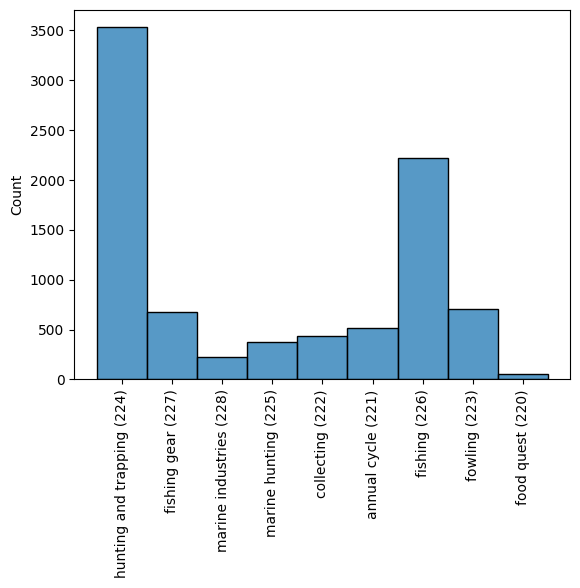

########## None NN 

########## Training MLPClassifier

########## 0.9759174311926605
              precision    recall  f1-score   support

         220       0.99      0.99      0.99      1658
         222       0.77      0.73      0.75        86

    accuracy                           0.98      1744
   macro avg       0.88      0.86      0.87      1744
weighted avg       0.98      0.98      0.98      1744



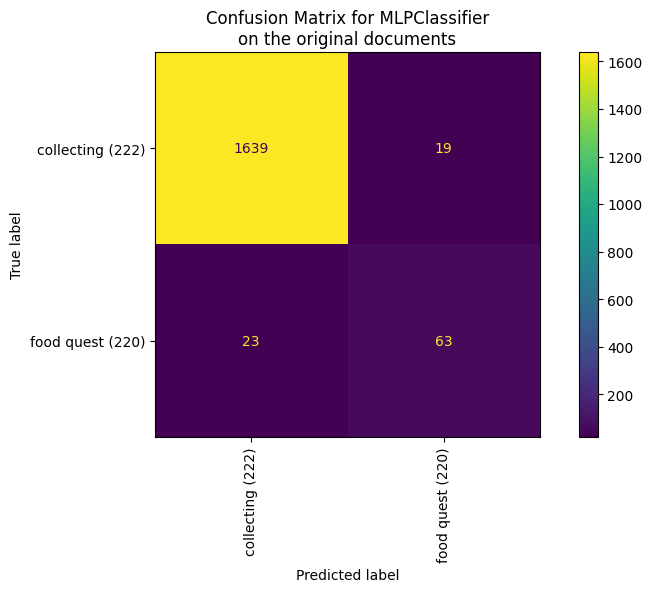

In [8]:
df=run(models=['NN'], specific_cat=222, exact=True, verbose=True)

In [11]:
df[df['predicted_MLPClassifier'] != df['ocms']][['predicted_MLPClassifier', 'ocms', 'culture', 'place', 'textrecord']]

,predicted_MLPClassifier,ocms,culture,place,textrecord
28591,220,224,Santal,India,{{224}} After he has performed the sacrifices ...
150971,220,226,Marshallese,Marshall Islands,"{{226}} When the catch is large, the surplus f..."
116047,220,224,Navajo,"Arizona, New Mexico, and Utah, United States",When the location chosen for the hunt was reac...
167287,220,226,Kuna,"San Blas coast and Islands, Panama",The overwhelming majority of animal protein co...
78469,220,223,Eyak,"Cordova and Copper River delta area, Valdez-Co...",The natives denied the use of slings and bolas.
...,...,...,...,...,...
78612,220,226,Ingalik,"Anvik, southwestern Yukon-Koyukuk Census Area,...",~~Where made~~ . Near where people live during...
163414,220,224,Samoyed,Nganasan,[% Figure 6. Plans for collective methods of ...
64186,220,224,San,"Kutse, Botswana",I thought trapping would be more popular among...
172885,220,223,Mataco,"Gran Chaco region, Bolivia, Argentina",[( {{223}} {{224}} A3. ~~Catapult shots~~ B...


# Specific categories

In [8]:
id_to_label['240']

'agriculture'

C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


########## None LR 

########## Training LogisticRegression

########## 0.8814265863825845
              precision    recall  f1-score   support

         224       0.92      0.96      0.94       727
         226       0.97      0.94      0.95       426
         241       0.81      0.86      0.83       570
         243       0.83      0.72      0.77       436

    accuracy                           0.88      2159
   macro avg       0.88      0.87      0.87      2159
weighted avg       0.88      0.88      0.88      2159

['hunting and trapping', 'fishing', 'tillage', 'cereal agriculture']             culture predicted_LogisticRegression
84702  Copper Inuit                          224
31573         Serbs                          243
23553       Burusho                          224
58342         Bemba                          241
58255         Bemba                          241
...             ...                          ...
61263           San                          224
62162        

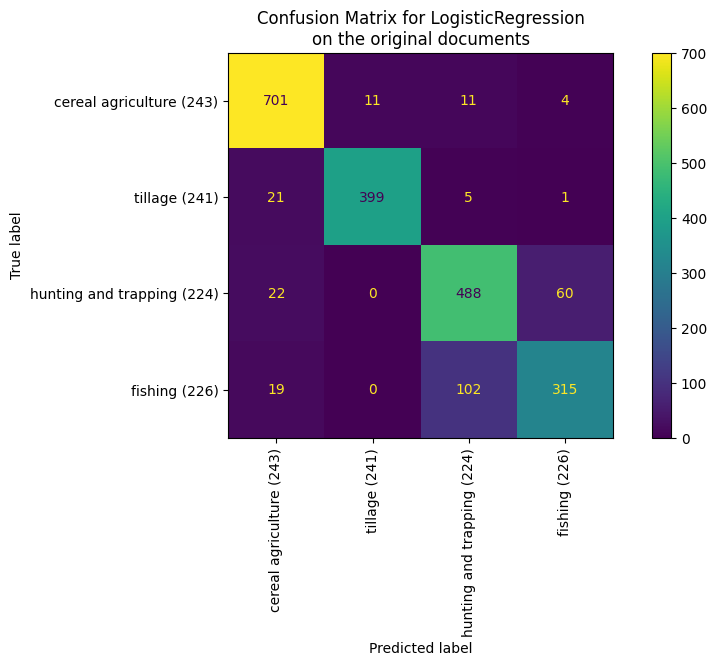

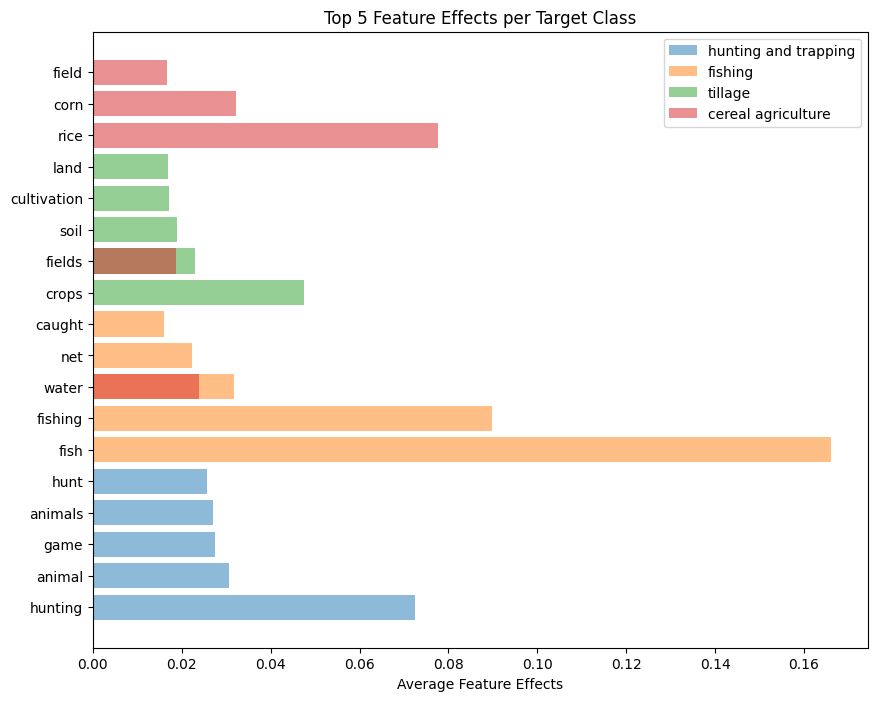

,Unnamed: 0,sreid,section,sectpar,sectgpar,title,hdoc,culture,pub.date,field.date,...,pub.lang,page,pageEid,prevPage,nextPage,textrecord,ocms,language,ocms_list,predicted_LogisticRegression
84702,94154,nd08-029-005012,nd08-029-004829,NaN,NaN,The people of the twilight,nd08-029,Copper Inuit,1959,1914-1916,...,English,[160],nd08-029-005002,nd08-029-004982,nd08-029-005018,{{224}} When Jennie and I arrived at the camp ...,224,en,[224],224
31573,33899,ef06-019-011725,ef06-019-011023,ef06-019-010917,NaN,Folk life and customs in the Kragujevac region...,ef06-019,Serbs,1973,not specified (pre-1921),...,English translation from Serbian,- 145 -,ef06-019-011659,ef06-019-011555,ef06-019-011767,"{{241}} To make corn thrive, bread should not ...",241,en,[241],243
23553,24945,av07-002-006835,av07-002-006234,av07-002-001834,NaN,Language hunting in the Karakoram,av07-002,Burusho,[1939],1920-1924- 1934-1935,...,English,239,av07-002-006818,av07-002-006793,av07-002-006850,{{241}} As autumn drew in we had begun to feel...,241,en,[241],224
58342,64434,fq05-002-015127,fq05-002-013970,fq05-002-012748,NaN,"Land, labour and diet in Northern Rhodesia: an...",fq05-002,Bemba,1939,1930-1934,...,English,322,fq05-002-015112,fq05-002-014905,fq05-002-015155,{{241}} The map in the Appendix shows how the ...,241,en,[241],241
58255,64341,fq05-002-013575,fq05-002-013338,fq05-002-012748,NaN,"Land, labour and diet in Northern Rhodesia: an...",fq05-002,Bemba,1939,1930-1934,...,English,306,fq05-002-013554,fq05-002-013505,fq05-002-013584,"{{241}} The sowing season lasts, in effect, fr...",241,en,[241],241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61263,67415,fx10-002-001565,fx10-002-001536,fx10-002-000067,NaN,The ?Auin: a contribution to the study of the ...,fx10-002,San,1910,1908,...,English translation from German,23,fx10-002-001507,fx10-002-001452,fx10-002-001584,There are no closed seasons on hunting.,224,en,[224],224
62162,68409,fx10-017-015010,fx10-017-014801,fx10-017-014506,NaN,The !Kung of Nyae Nyae,fx10-017,San,1976,1950-1961,...,English,300,fx10-017-014989,fx10-017-014928,fx10-017-015025,The party had hunted for eight days without su...,224,en,[224],224
12651,13171,am11-107-010208,am11-107-010120,am11-107-010117,NaN,Rice growing in the Tonkin delta,am11-107,Vietnamese,1935,No date,...,English translation from French,251,am11-107-010192,am11-107-010154,am11-107-010237,The first cleaning is done three weeks after t...,243,en,[243],243
12745,13265,am11-107-011058,am11-107-011056,am11-107-011037,NaN,Rice growing in the Tonkin delta,am11-107,Vietnamese,1935,No date,...,English translation from French,277,am11-107-011038,am11-107-010987,am11-107-011094,When the harvest is brought back to the farm e...,243,en,[243],243


In [12]:
run(models=['LR', 'RF'], chosen_categories=[224, 226, 241, 243])

# Cat vs subcategories (binary classification)

C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8717 documents - 3.86MB (training set)
2 categories
vectorize training done in 2.098s at 1.839MB/s
n_samples: 6973, n_features: 6825
n_samples: 1744, n_features: 6825


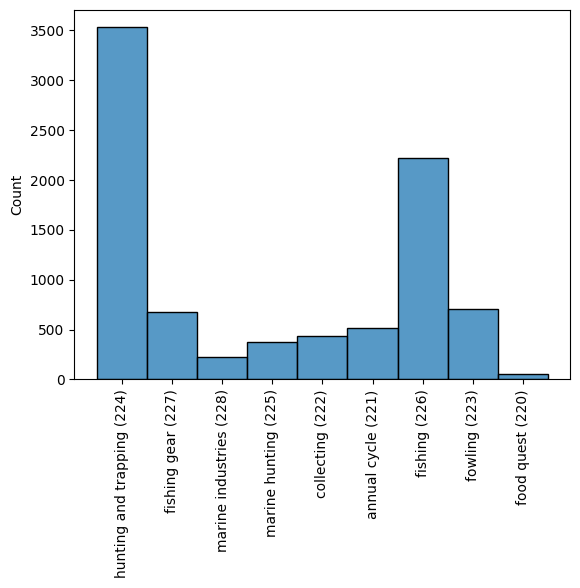

########## None LR 

########## Training LogisticRegression

########## 0.8887614678899083
              precision    recall  f1-score   support

         220       0.90      0.96      0.93      1326
         226       0.85      0.65      0.74       418

    accuracy                           0.89      1744
   macro avg       0.87      0.81      0.83      1744
weighted avg       0.89      0.89      0.88      1744

['food quest', 'fishing']                culture predicted_LogisticRegression
63892              San                          220
147537            Lesu                          226
100592        Iroquois                          220
91597          Kutenai                          226
152813   Woleai Region                          226
...                ...                          ...
88495   Nuu-chah-nulth                          220
98260          Mi'kmaq                          220
48708              Tiv                          226
69928          Bedouin              

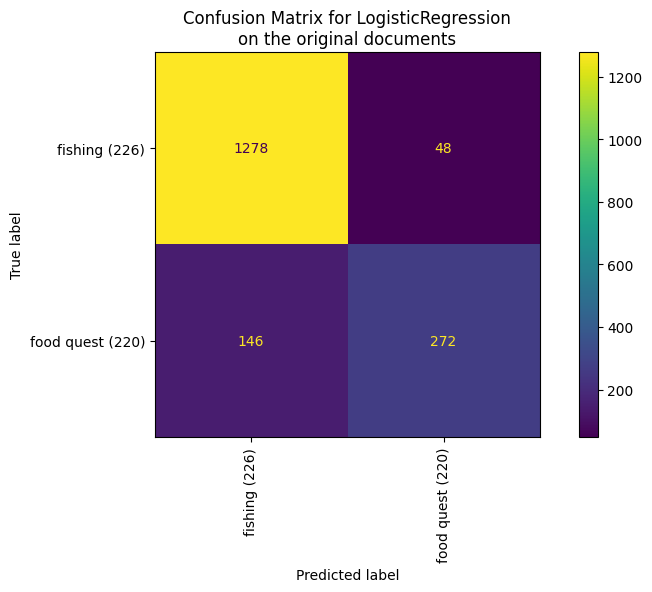

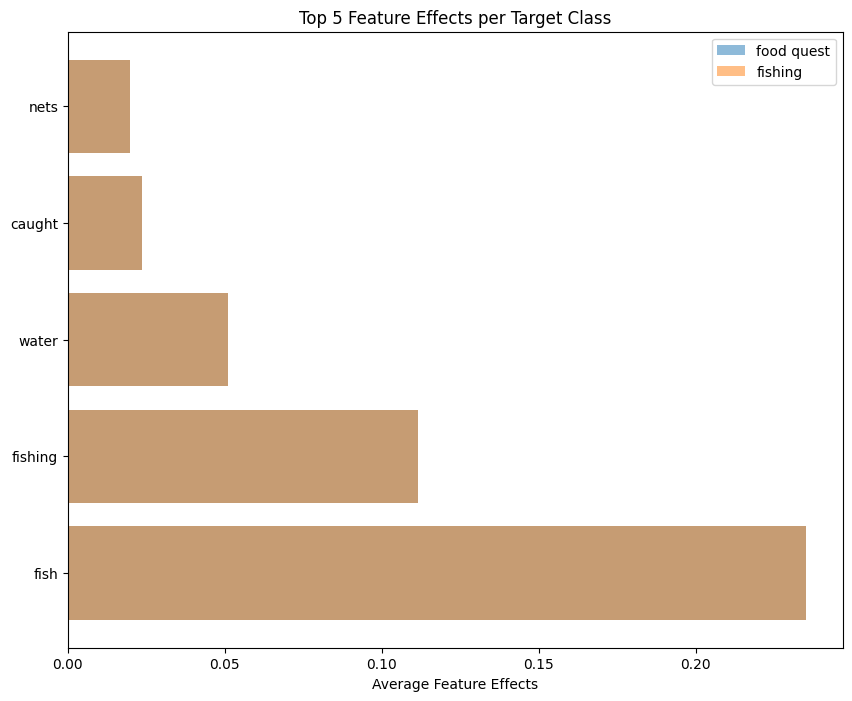

In [13]:
for i in [226]:#, 226, 241, 243]:
    df = run(models=['LR'], specific_cat=i, exact=True, verbose=True)

In [70]:
df.columns

Index(['Unnamed: 0', 'sreid', 'section', 'sectpar', 'sectgpar', 'title',
       'hdoc', 'culture', 'pub.date', 'field.date', 'byline', 'sreprev',
       'srenext', 'parent', 'division', 'coverage', 'place', 'roll',
       'pub.type', 'owcs', 'mainowc', 'samples', 'pub.lang', 'page', 'pageEid',
       'prevPage', 'nextPage', 'textrecord', 'ocms', 'language', 'ocms_list'],
      dtype='object')

In [14]:
df[['predicted_LogisticRegression', 'ocms']]

,predicted_LogisticRegression,ocms
63892,220,224
147537,226,226
100592,220,223
91597,226,227
152813,226,226
...,...,...
88495,220,225
98260,220,224
48708,226,226
69928,220,223


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8717 documents - 3.86MB (training set)
2 categories
vectorize training done in 13.686s at 0.282MB/s
n_samples: 6973, n_features: 6805
n_samples: 1744, n_features: 6805


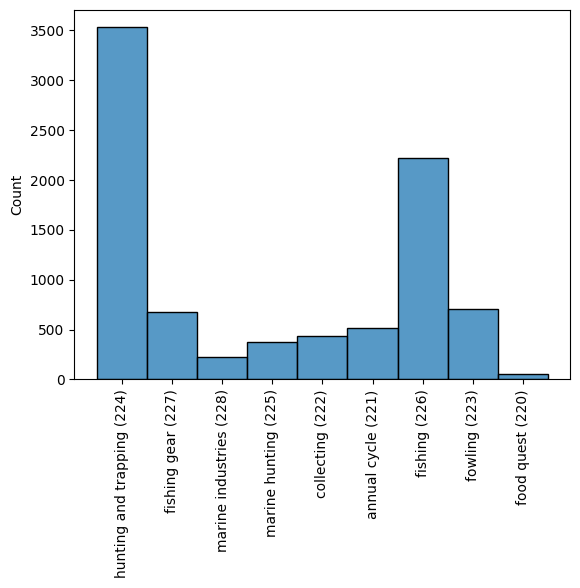

########## None LR 

########## Training LogisticRegression

########## 0.8532110091743119


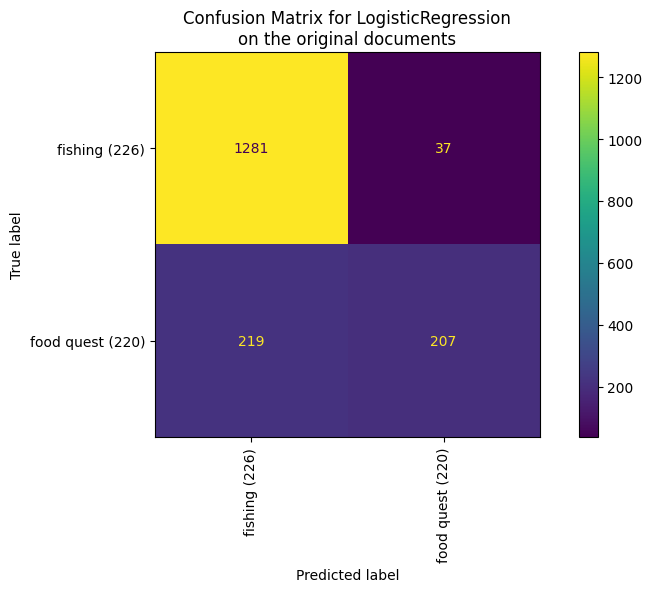

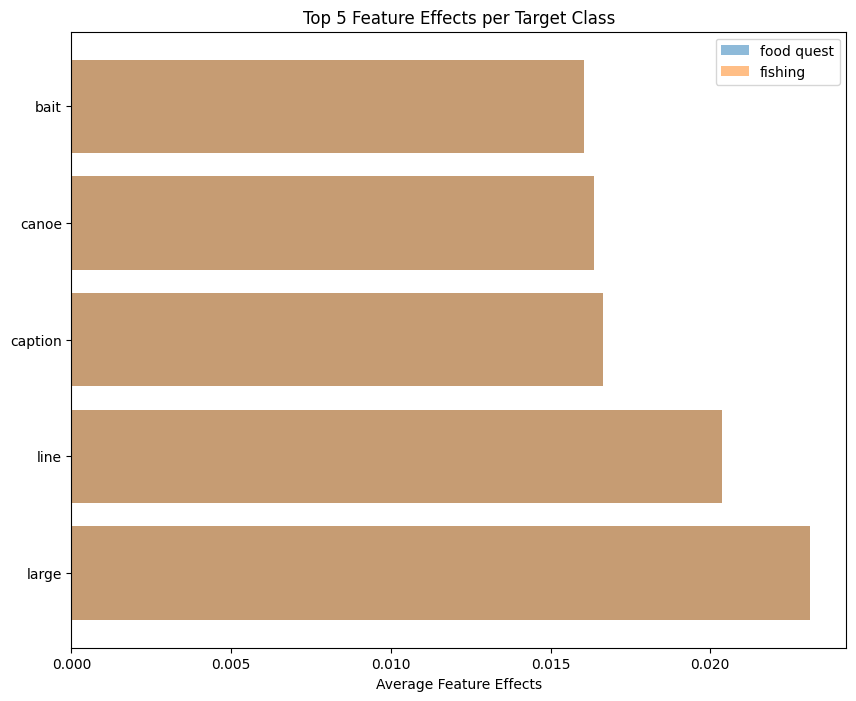

########## None RF 

########## Training RandomForestClassifier



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


########## 0.8652522935779816


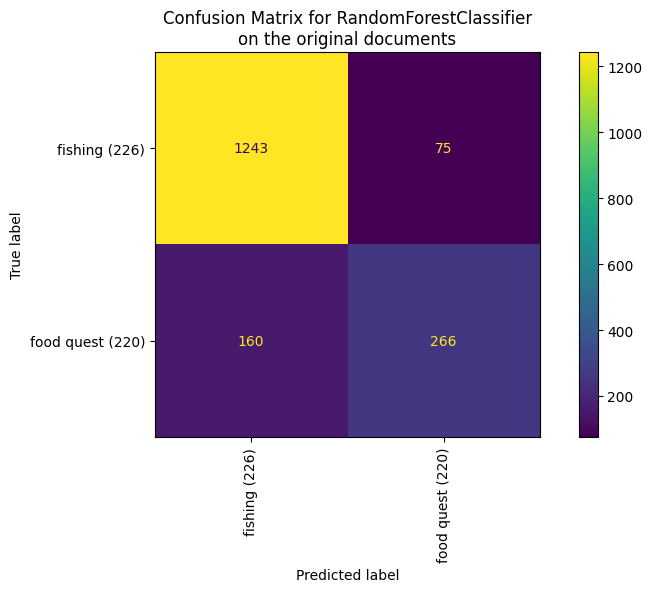

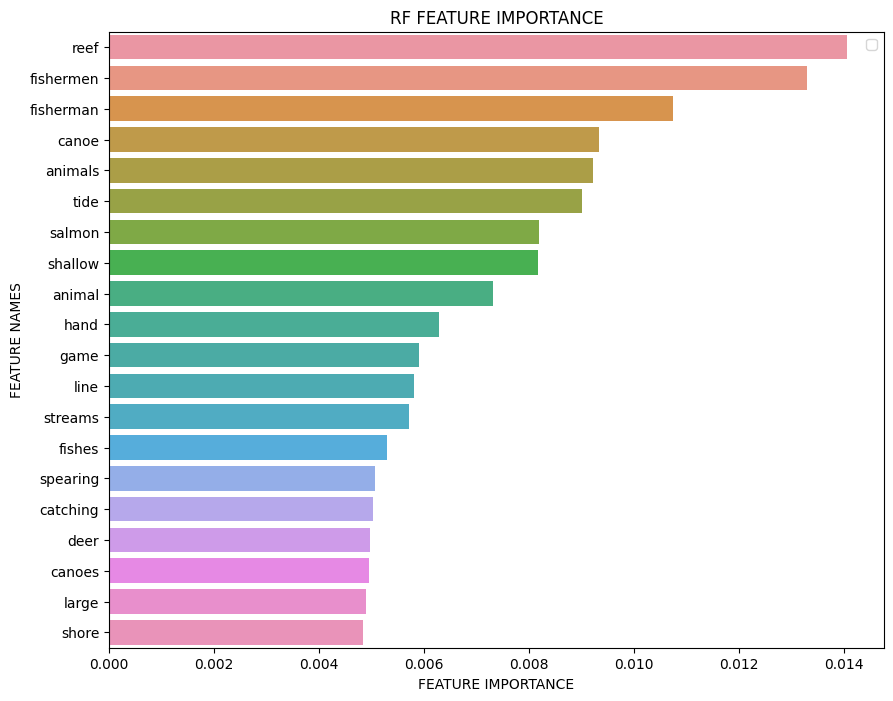

In [36]:
for i in [226]:#, 226, 241, 243]:
    run(models=['LR', 'RF'], specific_cat=i, exact=True, exclude=['hunting', 'hunter', 'hunters', 'fish', 'fishing', 'caught', 'catch', 'net', 'nets', 'river', 'hook', 'men', 'sea', 'water'], verbose=True)

# Cat vs subcategories (multi-label classification)

C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


########## None LR 

########## Training LogisticRegression

########## 0.7660550458715596
              precision    recall  f1-score   support

         220       0.00      0.00      0.00         8
         221       0.75      0.51      0.61       100
         222       0.94      0.60      0.74        83
         223       0.90      0.55      0.68       142
         224       0.75      0.96      0.84       715
         225       0.97      0.39      0.56        82
         226       0.74      0.88      0.81       426
         227       0.78      0.40      0.53       140
         228       1.00      0.10      0.19        48

    accuracy                           0.77      1744
   macro avg       0.76      0.49      0.55      1744
weighted avg       0.78      0.77      0.74      1744

['food quest', 'annual cycle', 'collecting', 'fowling', 'hunting and trapping', 'marine hunting', 'fishing', 'fishing gear', 'marine industries']            culture predicted_LogisticRegression
61441     

C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


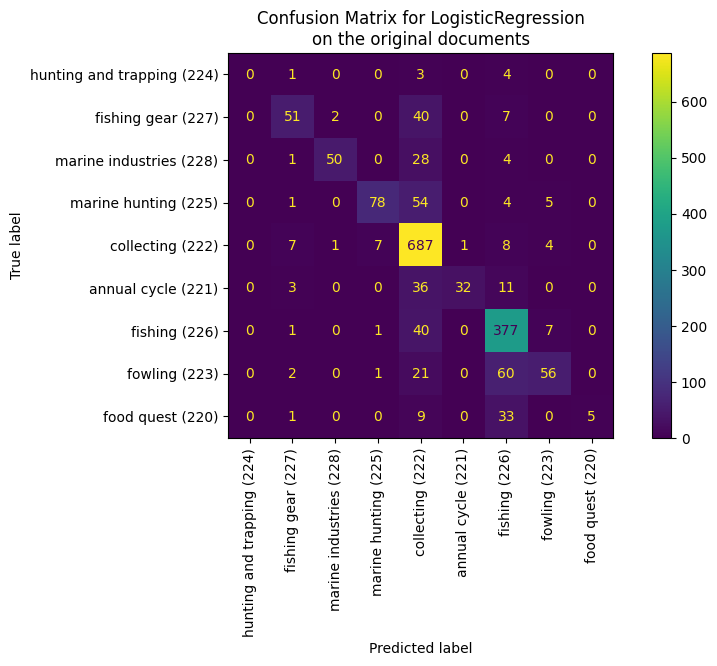

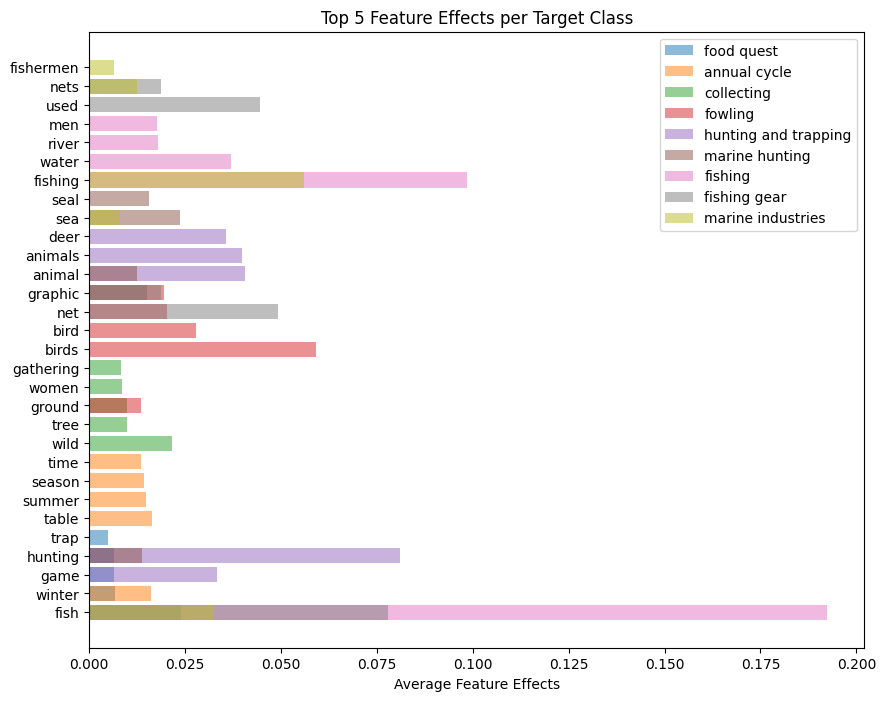

C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


########## None LR 

########## Training LogisticRegression

########## 0.7826834862385321
              precision    recall  f1-score   support

         220       0.00      0.00      0.00         8
         221       0.84      0.56      0.67        97
         222       1.00      0.59      0.74        78
         223       0.94      0.52      0.67       147
         224       0.75      0.98      0.85       729
         225       0.97      0.36      0.53        77
         226       0.78      0.91      0.84       444
         227       0.79      0.33      0.46       126
         228       1.00      0.13      0.23        38

    accuracy                           0.78      1744
   macro avg       0.78      0.49      0.55      1744
weighted avg       0.80      0.78      0.76      1744

['food quest', 'annual cycle', 'collecting', 'fowling', 'hunting and trapping', 'marine hunting', 'fishing', 'fishing gear', 'marine industries']              culture predicted_LogisticRegression
69955   

C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


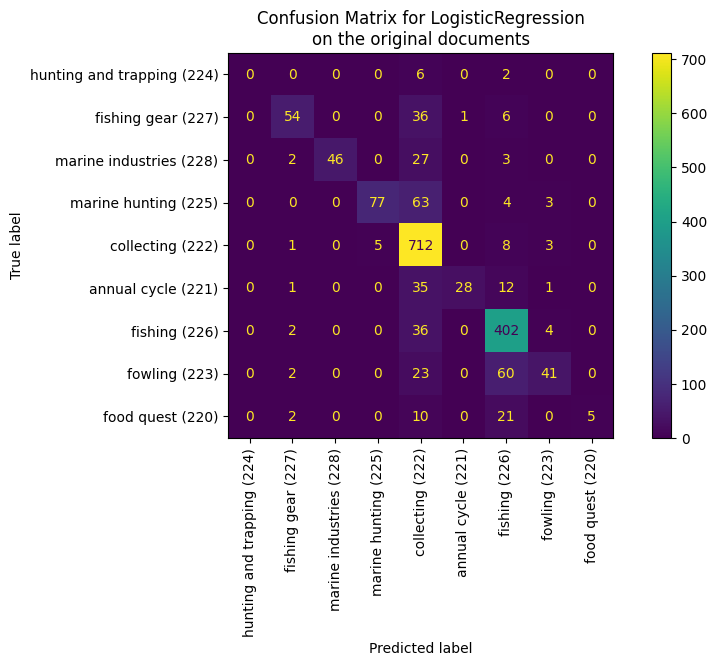

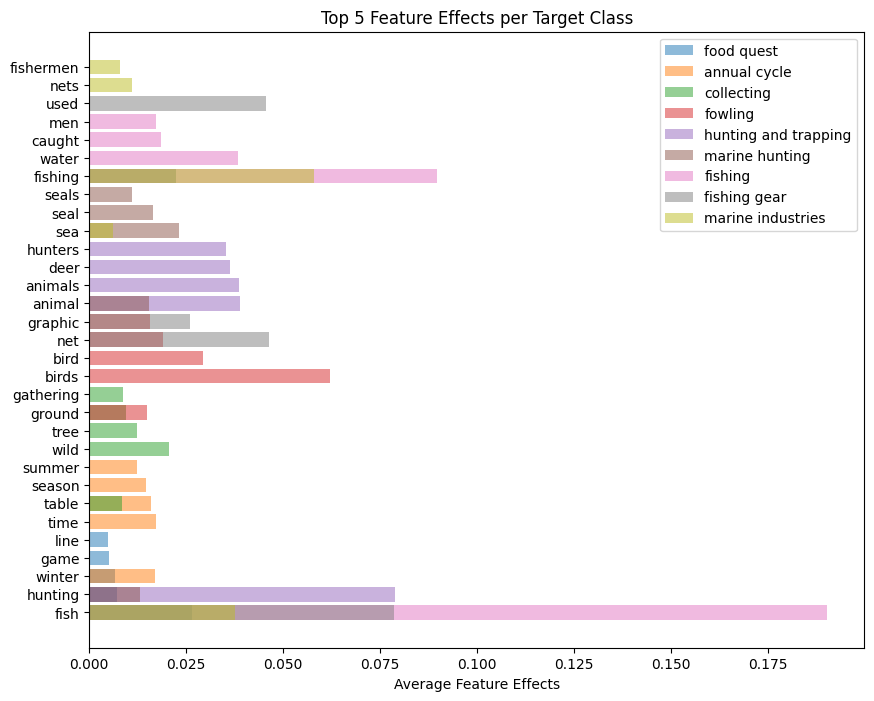

C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


########## None LR 

########## Training LogisticRegression

########## 0.6420281001832621
              precision    recall  f1-score   support

         240       0.00      0.00      0.00         1
         241       0.56      0.83      0.67       590
         242       0.70      0.08      0.14        87
         243       0.72      0.71      0.72       434
         244       0.69      0.58      0.63       242
         245       0.86      0.59      0.70       145
         246       0.00      0.00      0.00        26
         247       0.00      0.00      0.00         2
         248       0.71      0.14      0.23        37
         249       0.81      0.23      0.36        73

    accuracy                           0.64      1637
   macro avg       0.51      0.32      0.35      1637
weighted avg       0.66      0.64      0.62      1637

['agriculture', 'tillage', 'agricultural science', 'cereal agriculture', 'vegetable production', 'arboriculture', 'forage crops', 'floriculture', 'tex

C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


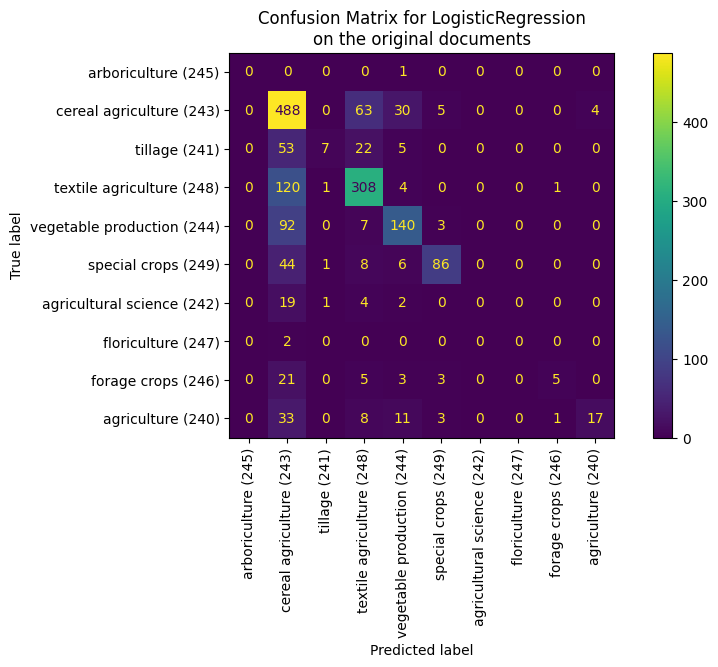

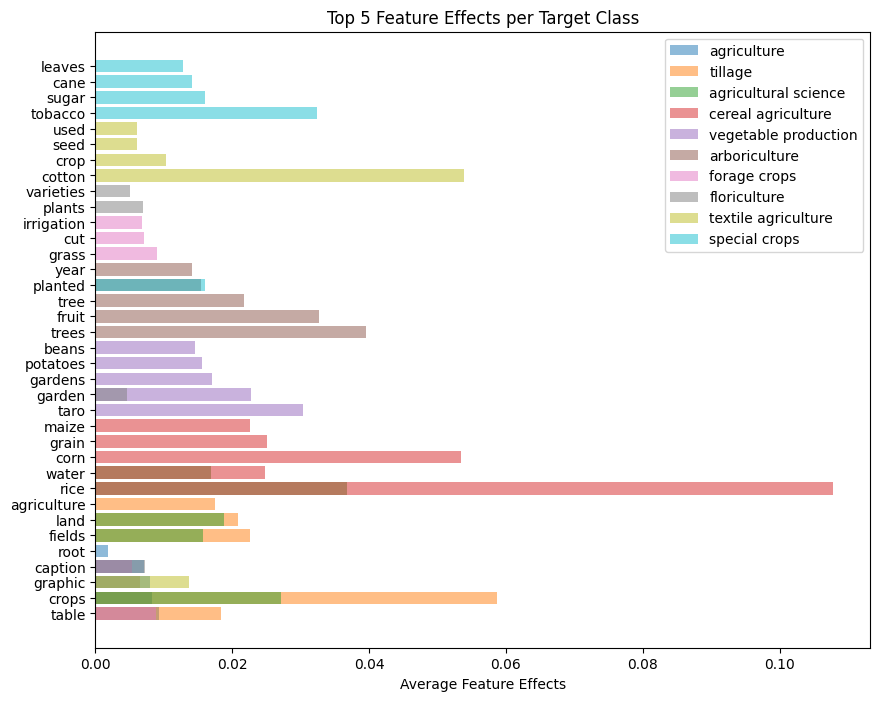

C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


########## None LR 

########## Training LogisticRegression

########## 0.664630421502749
              precision    recall  f1-score   support

         240       0.00      0.00      0.00         1
         241       0.57      0.83      0.67       555
         242       0.70      0.08      0.14        88
         243       0.73      0.75      0.74       436
         244       0.73      0.58      0.65       245
         245       0.86      0.70      0.77       172
         246       0.00      0.00      0.00        27
         247       0.00      0.00      0.00         4
         248       0.88      0.36      0.51        39
         249       1.00      0.24      0.39        70

    accuracy                           0.66      1637
   macro avg       0.55      0.35      0.39      1637
weighted avg       0.69      0.66      0.64      1637

['agriculture', 'tillage', 'agricultural science', 'cereal agriculture', 'vegetable production', 'arboriculture', 'forage crops', 'floriculture', 'text

C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


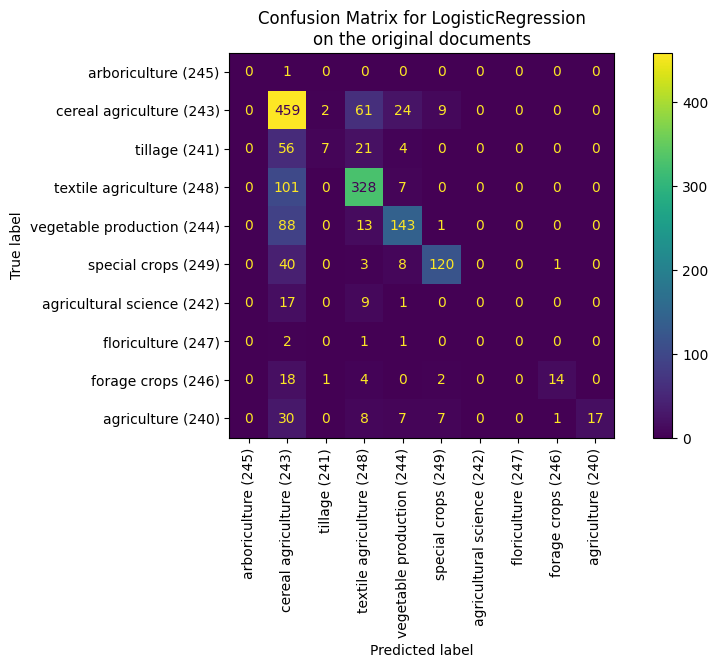

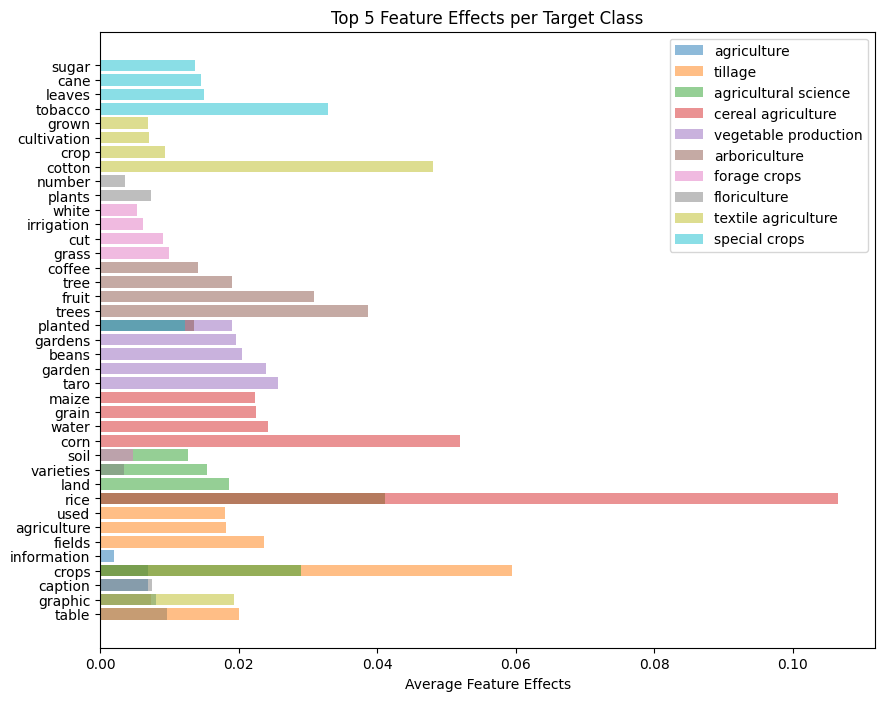

In [15]:
for i in [224, 226, 241, 243]:
    run(models=['LR', 'RF'], specific_cat=i, exact=False)

# Archive

In [ ]:
data = []
for i in [224, 226, 241, 243]:
    data.append(df[ df['ocms_list'].map(lambda x: len(x) == 1 and x[0] == i) ])
data = pd.concat(data)

In [ ]:
sns.histplot(data['ocms'])
# data.ocms.hist()

In [ ]:
s = time.time()

tfidf_vec = TfidfVectorizer(min_df=3, # If a token appears fewer times than this, across all documents, it will be ignored
                             # tokenizer=nltk.word_tokenize, # we use the nltk tokenizer
                             tokenizer=preprocessing.tokenize_data, # we use the custom tokenizer
                             stop_words='english')#stopwords.words('english')) # stopwords are removed

tfidf_text = tfidf_vec.fit_transform(data['textrecord'])


e = time.time()
print("Elapsed time during the whole program in seconds:",
                                         e-s) 

## Random Forest

In [ ]:
# clf = RandomForestClassifier(random_state=0)
# # cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

# param_grid = {"max_depth": [3, None],
#               "min_samples_split": [5, 10],}

# search = HalvingGridSearchCV(clf, param_grid, resource='n_estimators',
#                              max_resources=10,
#                              cv=5,
#                              random_state=0).fit(X_train, y_train)
# search.best_params_  # {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 9}

In [ ]:
# search.best_estimator_.score(X_test, y_test)

In [ ]:
# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

In [ ]:
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

# n_scores = cross_val_score(model, 
#                            tfidf_text, data['parent_ocms'], 
#                            scoring='accuracy', 
#                            cv=cv, 
#                            n_jobs=-1, 
#                            error_score='raise')

In [ ]:

# print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [ ]:
# Evaluate the model on the testing set
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

In [ ]:
preds = model.predict(X_test)
print(preds)

In [ ]:
plots.make_cm(model, preds, y_test, data['ocms'].uniqueque())

In [ ]:
report = classification_report(y_test, preds, digits = 3)
print(report)

In [ ]:
_test = df['textrecord'][SELECTED*2:SELECTED*3]
_test = text_vec.transform(_test)

In [ ]:
rf.predict(_test)[100:300]

In [ ]:
# Evaluate the model on the testing set
accuracy = rf.score(X_test, y_test)
print("Accuracy:", accuracy)

## Logisitc Regression

In [ ]:

pipe = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=10000))

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_text, data['parent_ocms'], test_size=0.2)

In [ ]:
pipe.fit(X_train, y_train)

In [ ]:
pipe.score(X_test, y_test)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
clf.predict(X[:2, :])

In [ ]:
clf.predict_proba(X[:2, :]).shape

## KNN

In [ ]:
k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(X_train)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y_train, cv=5)
    scores.append(np.mean(score))

In [ ]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [ ]:
pipe = make_pipeline(StandardScaler(with_mean=False),
                     KNeighborsClassifier(n_neighbors=16))

In [ ]:
pipe.fit(X_train, y_train)

In [ ]:
pipe.score(X_test, y_test)

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Define a function to preprocess a text record
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower().strip() for token in doc 
              if not token.is_stop and not token.is_punct and token.lemma_ != '-PRON-']
    return tokens

In [ ]:
s = time.time()

# Apply the preprocess_text function to the textrecord column
df["processed_text"] = df["textrecord"].apply(preprocess_text)

    
e = time.time()


print("Elapsed time during the whole program in seconds:",
                                         e-s) 

In [ ]:
df.to_csv('data/splitted_preprocessed.csv')

In [ ]:
s = time.time()

nlp.pipe(df["textrecord"])


e = time.time()


print("Elapsed time during the whole program in seconds:",
                                         e-s) 

In [ ]:
# Preprocess data (e.g., remove missing values, encode categorical variables)

for doc in nlp.pipe(texts):
    # Do something with the doc here
    print([(ent.text, ent.label_) for ent in doc.ents])

    

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop("dependency_strength", axis=1), data["dependency_strength"], test_size=0.2)

In [ ]:
# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
# Evaluate the model on the testing set
accuracy = rf.score(X_test, y_test)
print("Accuracy:", accuracy)

# Links
- https://www.datacamp.com/tutorial/random-forests-classifier-python
- https://machinelearningmastery.com/random-forest-ensemble-in-python/
- https://github.com/WillKoehrsen/Data-Analysis/tree/master/random_forest_explained
- https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html
- https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
- **GREAT RESOURCE** https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py
- https://scikit-learn.org/stable/modules/ensemble.html#subsampling